In [613]:
"""
You can find some good intros here:
    http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf
    https://zhuanlan.zhihu.com/p/32626442
    https://cs231n.github.io/neural-networks-3/#hyper
"""
import numpy as np
# for ploting
import matplotlib as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [614]:
# Assume input shape is (N, 2)
class Env: 
    kDelta = 0.0001

    def getValue(self, x):
        # just a random function. check the figure below for its shape
        return (0.1 * (x.T[0]**2 + (-x.T[1]+2)**2) \
                - 12*(1+np.exp(abs(1.5*x.T[0]-4)))**-1 \
                - 12*(1+np.exp(abs(-1.5*x.T[1]-2)))**-1).T
    
    def getGradientX0(self, x):
        return (self.getValue(x + [self.kDelta, 0]) - self.getValue(x - [self.kDelta, 0])) / (self.kDelta * 2)
    
    def getGradientX1(self, x):
        return (self.getValue(x + [0, self.kDelta]) - self.getValue(x - [0, self.kDelta])) / (self.kDelta * 2)    
    
    def getGradient(self, x):
        gradient = np.zeros(x.shape)
        gradient[:,0] = self.getGradientX0(x)
        gradient[:,1] = self.getGradientX1(x)
        return gradient

In [615]:
def plotCurve(X, Y, Z):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    
    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()
    
def plotLine(X, Y, Z, traces=[]):
    plt.contourf(X,Y,Z)
    plt.contour(X,Y,Z)
    if len(traces) > 0:
        for label, trace in traces:
            plt.plot(trace[:,1], trace[:,0], label=label)
        plt.legend()
    plt.show()

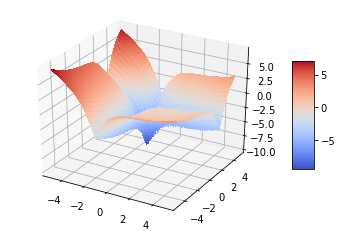

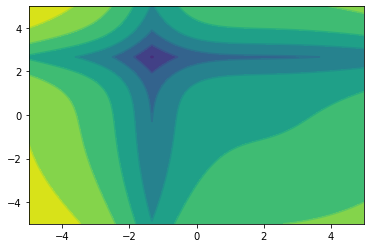

In [616]:
env = Env()
X = np.arange(-5, 5, 0.01)
Y = np.arange(-5, 5, 0.01)
X, Y = np.meshgrid(X, Y)
Z = env.getValue(np.array([X, Y]).T)

plotCurve(X, Y, Z)
plotLine(X, Y, Z)

In [617]:
min_crd = np.unravel_index(np.argmin(Z, axis=None), Z.shape)
print('min coordinates: ', Y[min_crd[1]][0], X[0][min_crd[0]])
print('min value', Z[min_crd])

min coordinates:  -1.3300000000000782 2.6699999999998365
min value -10.148220062500965


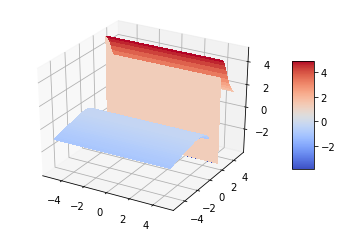

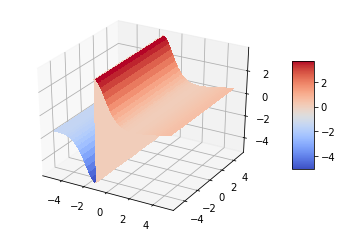

In [618]:
G0 = env.getGradientX0(np.array([X, Y]).T)
plotCurve(X, Y, G0)

G1 = env.getGradientX1(np.array([X, Y]).T)
plotCurve(X, Y, G1)

In [619]:
def naiveGD(init_pos, env, step, tolerance=0.0001, max_iter=5000):
    pos = np.array(init_pos)
    trace = []
    for _ in range(max_iter):
        trace.append([pos[0], pos[1]])
        pos_ = pos - env.getGradient(np.array([pos]))[0] * step
        if abs(env.getValue(pos) - env.getValue(pos_)) < tolerance:
            break
        else:
            pos = pos_
    return env.getValue(pos), np.array(trace)

In [620]:
def momentumGD(init_pos, env, step, tolerance=0.0001, max_iter=5000):
    pos = np.array(init_pos)
    rollover_rate = 0.9
    last_update = np.array([0., 0.])
    trace = []
    for _ in range(max_iter):
        trace.append([pos[0], pos[1]])
        
        update = rollover_rate * last_update + (1- rollover_rate) * env.getGradient(np.array([pos]))[0] * step
        pos_ = pos - update
        last_update = update
        
        if abs(env.getValue(pos) - env.getValue(pos_)) < tolerance:
            break
        else:
            pos = pos_
    return env.getValue(pos), np.array(trace)

In [621]:
def nesterovAcceleratedGD(init_pos, env, step, tolerance=0.0001, max_iter=5000):
    pos = np.array(init_pos)
    rollover_rate = 0.9
    last_update = np.array([0., 0.])
    trace = []
    for _ in range(max_iter):
        trace.append([pos[0], pos[1]])
        
        future_pos = pos + last_update
        future_grad =  env.getGradient(np.array([future_pos]))[0]
        update = rollover_rate * last_update + (1- rollover_rate) * future_grad * step
        pos_ = pos - update
        last_update = update
        
        if abs(env.getValue(pos) - env.getValue(pos_)) < tolerance:
            break
        else:
            pos = pos_
    return env.getValue(pos), np.array(trace)

In [622]:
def adaptiveGD(init_pos, env, step, tolerance=0.0001, max_iter=5000):
    pos = np.array(init_pos)
    grad_square_sum = np.array([0., 0.])
    trace = []
    for _ in range(max_iter):
        trace.append([pos[0], pos[1]])
        
        curr_grad = env.getGradient(np.array([pos]))[0]
        grad_square_sum += curr_grad**2
        pos_ = pos - curr_grad / np.sqrt(grad_square_sum + 1e-7) * step
        
        if abs(env.getValue(pos) - env.getValue(pos_)) < tolerance:
            break
        else:
            pos = pos_
    return env.getValue(pos), np.array(trace)

In [623]:
def rmsPropGD(init_pos, env, step, tolerance=0.0001, max_iter=5000):
    pos = np.array(init_pos)
    grad_square_sum = np.array([0., 0.])
    decay_rate = 0.9
    trace = []
    for _ in range(max_iter):
        trace.append([pos[0], pos[1]])
        
        curr_grad = env.getGradient(np.array([pos]))[0]
        grad_square_sum = decay_rate * grad_square_sum + (1 - decay_rate) * curr_grad**2
        pos_ = pos - curr_grad / np.sqrt(grad_square_sum + 1e-7) * step
        
        if abs(env.getValue(pos) - env.getValue(pos_)) < tolerance:
            break
        else:
            pos = pos_
    return env.getValue(pos), np.array(trace)

In [624]:
def adaptiveMomentumGD(init_pos, env, step, tolerance=0.0001, max_iter=5000):
    pos = np.array(init_pos)
    rollover_rate = 0.9
    decay_rate = 0.9
    last_update = np.array([0., 0.])
    grad_square_sum = np.array([0., 0.])
    trace = []
    for t in range(1, max_iter+1):
        trace.append([pos[0], pos[1]])
        
        # from momentum
        curr_grad = env.getGradient(np.array([pos]))[0]
        curr_update = rollover_rate * last_update + (1- rollover_rate) * curr_grad * step
        corrected_curr_update = curr_update / (1 - rollover_rate**t)
        
        # from RMSprop
        grad_square_sum = decay_rate * grad_square_sum + (1 - decay_rate) * curr_grad**2
        corrected_grad_square_sum = grad_square_sum / (1 - decay_rate**t)
        
        pos_ = pos - corrected_curr_update / np.sqrt(corrected_grad_square_sum + 1e-7)
        last_update = curr_update
        
        if abs(env.getValue(pos) - env.getValue(pos_)) < tolerance:
            break
        else:
            pos = pos_
    return env.getValue(pos), np.array(trace)

naive -10.015199082794817 5000
momentum -10.143949351322659 2547
NAG -9.73133151542229 4202
AdaGrad -4.970628245404163 562
RMSprop -9.908145692299922 5000
Adam -10.156644717246873 1044


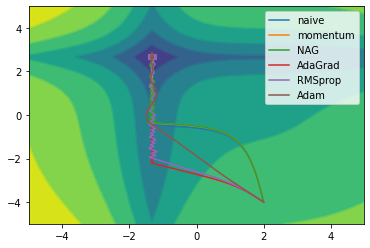

In [625]:
init_pos = [-4, 2]
converge_err = 0.00001
max_iter = 5000
traces = []

label = 'naive'
res, trace_naive = naiveGD(init_pos, env, step=0.01, tolerance=converge_err, max_iter=max_iter)
print(label, res, len(trace_naive))
traces.append([label, trace_naive])

label = 'momentum'
res, trace_momentum = momentumGD(init_pos, env, step=0.01, tolerance=converge_err, max_iter=max_iter)
print(label, res, len(trace_momentum))
traces.append([label, trace_momentum])

label = 'NAG'
res, trace_NAG = nesterovAcceleratedGD(init_pos, env, step=0.01, tolerance=converge_err, max_iter=max_iter)
print(label, res, len(trace_NAG))
traces.append([label, trace_NAG])

label = 'AdaGrad'
res, trace_AdaGrad = adaptiveGD(init_pos, env, step=0.1, tolerance=converge_err, max_iter=max_iter)
print(label, res, len(trace_AdaGrad))
traces.append([label, trace_AdaGrad])

label = 'RMSprop'
res, trace_RMSprop = rmsPropGD(init_pos, env, step=0.1, tolerance=converge_err, max_iter=max_iter)
print(label, res, len(trace_RMSprop))
traces.append([label, trace_RMSprop])

label = 'Adam'
res, trace_Adam = adaptiveMomentumGD(init_pos, env, step=0.1, tolerance=converge_err, max_iter=max_iter)
print(label, res, len(trace_Adam))
traces.append([label, trace_Adam])

plotLine(X, Y, Z, traces)